In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!(cp 'drive/MyDrive/cleandata-2.csv' sample_data/)

Mounted at /content/drive


#Manual de Usuario

Para utilizar el programa desarrollado, ejecute la Sección 'Algoritmo guiado por gramática' entera y posteriormente diríjase a la Sección 'Material para el Usuario'. En esta última encontrará instrucciones sobre como utilizar el software propuesto.

Si desea consultar información sobre las pruebas que han realizado los autores para comprobar el rendimiento del algoritmo abra la Sección 'Pruebas del algoritmo'. Si únicamente desea utilizar el programa propuesto ignore esta sección y pase directamente a la sección final

# **La Sección 'Algoritmo guiado por gramática' contiene el código fuente necesario para ejecutar el programa.**

#Algoritmo guiado por gramática



In [1]:
#Se importan las librerías necesarias
import pandas as pd
import numpy as np
import math
import random
from copy import deepcopy
from google.colab import output
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from time import time
import matplotlib.pyplot as plt
!(pip install binarytree)
from binarytree import Node,get_parent,tree
from scipy.stats import kendalltau


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00


##Preprocesado de los datos

In [ ]:
def preprocesar_datos(df):
  #Se eliminan las columnas con muchos valores vacíos, ya que
  #molestarían en el proceso de búsqueda
  empty_cols = []
  for column in df.columns:
      empty_values = df[column].isnull().sum() #Obtención del número de valores vacíos de la columna
      if empty_values >= len(df)*0.75:
        empty_cols.append(column)

  df_encoded = df.drop(columns=empty_cols)

  #Se eliminan las columnas con un solo valor posible, debido a que
  #una condición
  unique_columns = []
  for column in df_encoded.columns:

      unique_values = len(df_encoded[column].unique())#Obtención del número de posibles valores que toma la columna
      if unique_values==1:
        unique_columns.append(column)

  df_encoded = df_encoded.drop(columns=unique_columns)

  #Codificación de los valores categóricos para un procesamiento más fácil
  columns = df_encoded.columns

  columnas_cat = []
  encoders = []

  for column in columns:
      if type(df[column][1]) == str or df[column].dtype == 'object':
          encoder = LabelEncoder()
          df_encoded[column] = encoder.fit_transform(df[column])
          encoders.append(encoder)
          columnas_cat.append(column)


  #Se devuelven el dataset procesado, las columnas de los valores categóricos y los encoders para
  #poder deshacer el cambio de las columnas categóricas
  return df_encoded,columnas_cat,encoders

##Funciones Auxiliares

In [ ]:
#Función que devuelve el p-valor, dadas dos correlaciones
def get_p_value_normal(kendallN,kendallM,sizeN,sizeM):
	if kendallN == 1:
		a=math.inf
	elif kendallN == -1:
		a=-math.inf
	else:
		a=np.arctanh(kendallN)
	if kendallM == 1:
		b=math.inf
	elif kendallM == -1:
		b=-math.inf
	else:
		b=np.arctanh(kendallM)
	z = (a-b)/np.sqrt((1/(sizeN-3)) + (1/(sizeM-3)))
	z_value = abs(z)*2
	def get_cdf_normal(z_value):
		return 0.5 * (1 + math.erf(z_value / math.sqrt(2)))
	p_value = 1 - get_cdf_normal(abs(z_value))
	return p_value


In [ ]:
#Obtiene para cada columna del conjunto de datos, el rango de valores que toma,
#El resultado obtenido de la función se usará para que no se definan condiciones imposibles.
def get_rangos(df_encoded,columnas_cat,variables):
  rangos = []
  #Las variables que se usan para las correlaciones no se usan en las condiciones
  columnas = [x for x in df_encoded.columns if x not in variables]

  for columna in columnas:
      indice = df_encoded.columns.get_loc(columna)

      maximo = df_encoded[columna].max()
      minimo = df_encoded[columna].min()

      es_categorico = columna in columnas_cat

      #rangos[i][2] indica si es categórico(True)
      rangos.append([indice, [minimo, maximo], es_categorico])
  return rangos


In [ ]:
#Devuelve un número (tam) de condiciones aleatorias
def generar_solucion_aleatoria_arbol(rangos,tam):
  n_feat= tam
  feats = random.sample(rangos,n_feat)
  sol = []
  for f in feats:
    if f[2]:
      #Es categórica
      sol.append([f[0],random.randint(f[1][0],f[1][1])])

    else:
      n1 = random.uniform(f[1][0],f[1][1])
      n2 = random.uniform(f[1][0],f[1][1])
      sol.append([f[0],[min(n1,n2),max(n1,n2)]])
  return sol


In [ ]:
#Genera una solución aleatoria en forma de árbol aplicando la gramática
#depth indica la profundidad máxima al generar las soluciones
def generate_logical_tree_in(rangos,depth=3, primer_pick=False):
    if depth == 0:
      #Crea un nodo hoja (condición)
        return Node(str(generar_solucion_aleatoria_arbol(rangos,1)[0]))


    operator = random.choice(["&", "|"])

    #Las profundidades se los subárboles se eligen aleatoriamente
    left_depth = random.randint(0, depth - 1)
    right_depth = random.randint(0, depth - 1)

    #Se asigna el nodo actual y se establecen los hijos recursivamente
    node = Node(operator)
    node.left = generate_logical_tree_in(rangos,left_depth, primer_pick)
    node.right = generate_logical_tree_in(rangos,right_depth, primer_pick)

    return node



#Función que obtiene el subconjunto que representa la solución
def evaluate_tree_expression_in(root, dataframe):
    def obtener_cadena(root):

      if root.left is None and root.right is None:
          l = eval(root.value)
          if isinstance(l[1],list):
            #Columna continua
            c2, li, ls = l[0], l[1][0], l[1][1]
            condition = f"(dataframe.iloc[:, {c2}].between({li}, {ls}))"
          else:
            if l[0] == -1:
              #Operadores neutros de AND y OR, necesarios para operador de
              #purificación (reconstrucción)

              if l[1] == 'a':
                #Condición que representa el conjunto de datos entero
                condition = f"(dataframe.iloc[:,0] == dataframe.iloc[:,0])"
              else:
                #Condición que representa el conjunto vacío
                condition = f"(dataframe.iloc[:,0] != dataframe.iloc[:,0])"
            else:
              #Columna categórica
              c1, d = l[0], l[1]
              condition = f"(dataframe.iloc[:, {c1}] == {d})"
          return condition

      left_condition = obtener_cadena(root.left)
      right_condition = obtener_cadena(root.right)

      return '('+left_condition+')'+root.value+'('+right_condition+')'
    #Se evalua la  expresión en forma de string y se obtiene el dataframe
    expression = obtener_cadena(root)
    return dataframe[eval(expression)]

#Dado un árbol, se obtienen las condiciones en una lista para poder trabajar
#fácilmente con ellas
def from_tree_to_gen(root):
    genes = []

    def obtener_listas(node):
        nonlocal genes
        if node is None:
            return
        if node.left is None and node.right is None:
            #El nodo es hoja y por tanto una condición
            genes.append(eval(node.value))
        obtener_listas(node.left)
        obtener_listas(node.right)
    #Se recorre recursivamente el árbol y se guardan los nodos hoja
    obtener_listas(root)
    return genes

#Dada una lista de condiciones, se añaden al árbol, función inversa de la
#anterior
def insert_gen_to_tree(root, gens):
    #Los valores se insertan recorriendo el árbol en-orden
    def insert_value(node):
        nonlocal gens_index
        if node is None:
            return
        if node.left is None and node.right is None:
            node.value = str(gens[gens_index])
            gens_index += 1
        else:
            insert_value(node.left)
            insert_value(node.right)

    gens_index = 0
    insert_value(root)
    return root



In [ ]:
#Función que simplifica el árbol eliminando nodos innecesarios
def purificar_arbol(arbol, df, tam_min):
    tree = arbol.clone()

    def eliminar_inutiles(tree, parent=None):
        if tree is None or (tree.left is None and tree.right is None):
            return

        lmod = False
        rmod = False
        #Se va mirando si la rama derecha o izquierda representan todo el conjunto o el conjunto vacío
        # y se sustituyen por [-1,'a'] o [-1,'v'] respectivamente.

        #lmod y rmod indica si se ha simnplificado a la derecha o izquierda, en ese caso
        # no se deberá seguir procesando en esa dirección

        #Por la forma en la que se procesa, en el árbol resultante no quedan las condiciones neutras ([-1,x])
        #Estas se eliminan durante el proceso de purificado por lo siguiente:
        # {vacío} OR x = x
        # {conjunto_completo} OR x = {conjunto_completo}
        # {vacío} AND x = {vacío}
        # {conjunto_completo} AND x = x
        if parent:
            #Caso en el que el nodo usado no es el nodo raíz

            # Evaluación de la rama izquierda
            subcl = evaluate_tree_expression_in(tree.left, df)

            if tree.value == '&':
                if len(subcl) == 0:
                    lmod = True
                    if parent.left == tree:
                        parent.left = Node(str([-1, 'v']))
                    else:
                        parent.right = Node(str([-1, 'v']))
                elif len(subcl) == len(df):
                    lmod = True
                    if parent.left == tree:
                        parent.left = tree.right
                    else:
                        parent.right = tree.right
            else:
                if len(subcl) == 0:
                    lmod = True
                    if parent.left == tree:
                        parent.left = tree.right
                    else:
                        parent.right = tree.right
                elif len(subcl) == len(df):
                    lmod = True
                    if parent.left == tree:
                        parent.left = Node(str([-1, 'a']))
                    else:
                        parent.right = Node(str([-1, 'a']))

            # Evaluación de la rama derecha
            subcr = evaluate_tree_expression_in(tree.right, df)
            if tree.value == '&':
                if len(subcr) == 0:
                    rmod = True
                    if parent.left == tree:
                        parent.left = Node(str([-1, 'v']))
                    else:
                        parent.right = Node(str([-1, 'v']))
                elif len(subcr) == len(df):
                    rmod = True
                    if parent.left == tree:
                        parent.left = tree.left
                    else:
                        parent.right = tree.left
            else:
                if len(subcr) == 0:
                    rmod = True
                    if parent.left == tree:
                        parent.left = tree.left
                    else:
                        parent.right = tree.left
                elif len(subcr) == len(df):
                    rmod = True
                    if parent.left == tree:
                        parent.left = Node(str([-1, 'a']))
                    else:
                        parent.right = Node(str([-1, 'a']))

        else:
          #Caso en el que el nodo usado es el nodo raíz
          if tree.left is not None:
            subcl = evaluate_tree_expression_in(tree.left, df)
            if tree.value == '&':
              if len(subcl) == 0:

                lmod = True
                tree = Node(str([-1,'v']))
              elif len(subcl) == len(df):
                lmod = True
                tree = tree.right

            elif tree.value == '|':
              if len(subcl) == 0:
                lmod = True
                tree = tree.right
              elif len(subcl) == len(df):
                lmod = True
                tree = Node(str([-1,'a']))

          if tree.right is not None:
            subcr = evaluate_tree_expression_in(tree.right, df)

            if tree.value == '&':
              if len(subcr) == 0:

                lmod = True
                tree = Node(str([-1,'v']))
              elif len(subcr) == len(df):
                lmod = True
                tree = tree.left

            elif tree.value == '|':
              if len(subcr) == 0:
                lmod = True
                tree = tree.left
              elif len(subcr) == len(df):
                lmod = True
                tree = Node(str([-1,'a']))


        # Llamadas recursivas
        if not lmod:
            eliminar_inutiles(tree.left, tree)
        if not rmod:
            eliminar_inutiles(tree.right, tree)
        return tree


    return eliminar_inutiles(tree)




In [ ]:
#Función que transforma una condición en una cadena de texto( de cara a mostrársela al usuario de forma legible)
def gen_to_cond(gen,columnas_cat,encoders,df):

  r = "("
  if gen[0]==-1:
    return None
  col = df.columns[gen[0]]
  r+="\'"+col+"\' "
  if type(gen[1]) == list:
    #Columna numérica
    r+="IN "+str(gen[1])
  else:
    #Columna categórica

    #Obtener el ínidice de la columna en las columnas codificadas
    #Este índice se corresponde con el de el encoder usado para codificar la columna
    i = columnas_cat.index(df.columns[gen[0]])
    #Se usan los encoders para obtener el valor de la columna sin codificar
    #Es decir para mostrar: 'Estudios'='Doctorado' en lugar de 'Estudios'=3
    v = encoders[i].inverse_transform([gen[1]])[0]
    if type(v)!= str:
      v = str(v)
    r+="= \'"+v+"\'"
  r+=")"
  return r



In [ ]:
#Función que construye la consulta a partir de una solución
def from_tree_to_str(root,columnas_cat,encoders, dataframe,tam_min):
    def obtener_cadena(root):
        # El nodo es hoja
        if root.left is None and root.right is None:
            l = eval(root.value)
            #Se transforma la condición de la hoja en una cadena legible
            return gen_to_cond(l,columnas_cat,encoders, dataframe)

        # El nodo es un operador
        if root.value == '&':
            text = " AND "
        else:
            text = " OR "

        left_condition = obtener_cadena(root.left)
        right_condition = obtener_cadena(root.right)
        return f"({left_condition}{text}{right_condition})"
    #Se purifica el árbol antes de convertirlo en consulta, para simplificarla.
    return obtener_cadena(purificar_arbol(root, dataframe, tam_min))

In [ ]:
#Función que muestra de forma gráfica la diferencia de correlaciones dadas unas variables y una solución
#Está pensada para soluciones buenas, es decir no se comprueba si el tamaño del grupo es válido, se asume que sí
def plot_corrs(arbol, variables, df):
    #Se obtienen todos los pares posibles
    pares = []
    for i in range(len(variables)):
        j = i + 1
        while j < len(variables):
            pares.append((variables[i], variables[j]))
            j += 1
    #Se obtiene el grupo que representa la solución y su complementario
    subc = evaluate_tree_expression_in(arbol, df)
    complementario = df.drop(subc.index)[variables]
    for p in pares:
        l1 = subc[p[0]].values
        l2 = subc[p[1]].values
        l3 = complementario[p[0]].values
        l4 = complementario[p[1]].values
        #Se ignoran las instacias con algún valor vacío
        new_l1 = [l1[i] for i in range(len(l1)) if not math.isnan(l1[i]) and not math.isnan(l2[i])]
        new_l2 = [l2[i] for i in range(len(l2)) if not math.isnan(l1[i]) and not math.isnan(l2[i])]



        new_l3 = [l3[i] for i in range(len(l3)) if not math.isnan(l3[i]) and not math.isnan(l4[i])]
        new_l4 = [l4[i] for i in range(len(l4)) if not math.isnan(l3[i]) and not math.isnan(l4[i])]


        # Calcular correlaciones
        corr1, _ = kendalltau(new_l1, new_l2)
        corr2, _ = kendalltau(new_l3, new_l4)

        # Crear la figura y los subplots
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        # Plot del grupo con línea de regresión
        fit1 = np.polyfit(new_l1, new_l2, 1)
        fit_fn1 = np.poly1d(fit1)
        axs[0].plot(new_l1, fit_fn1(new_l1), '--k')
        axs[0].scatter(new_l1, new_l2)
        axs[0].set_title(f'Kendall: {corr1:.2f}, Size: {len(subc)}')
        axs[0].set_xlabel(p[0])
        axs[0].set_ylabel(p[1])

        # Plot del complementario con línea de regresión
        fit2 = np.polyfit(new_l3, new_l4, 1)
        fit_fn2 = np.poly1d(fit2)
        axs[1].plot(new_l3, fit_fn2(new_l3), '--k')
        axs[1].scatter(new_l3, new_l4)
        axs[1].set_title(f'Kendall: {corr2:.2f}, Size: {len(complementario)}')
        axs[1].set_xlabel(p[0])
        axs[1].set_ylabel(p[1])

        # Ajustar los espacios entre subplots
        plt.tight_layout()

        # Mostrar la figura
        plt.show()

##Definición del algoritmo

In [ ]:
#Función de evaluación
#
def evaluar_arbol(df,variables,rangos,arbol,umbral,verbose=False):
  #Se obtienen todos los pares posibles
  pares = []
  for i in range(len(variables)):
    j = i+1
    while j<len(variables):
      pares.append((variables[i],variables[j]))
      j+=1
  fitness = 0
  #Se obtiene el grupo que representa la solución y su complementario
  subc = evaluate_tree_expression_in(arbol,df)[variables]
  complementario = df.drop(subc.index)[variables]
  #Si el tamaño del grupo o de su complementario es menor que 5, la solución no es válida
  if len(subc)<5 or len(complementario)<5:
    return 0
  for p in pares:


    l1 =  subc[p[0]].values
    l2 =  subc[p[1]].values

    #Se ignoran las instacias con algún valor vacío
    new_l1 = [l1[i] for i in range(len(l1)) if not math.isnan(l1[i]) and not math.isnan(l2[i])]
    new_l2 = [l2[i] for i in range(len(l2)) if not math.isnan(l1[i]) and not math.isnan(l2[i])]
    #Si los conjuntos sin valores vacíos tienen menos de 4 elementos se invalida el par (suna 0 al fitness)
    #La función del p-valor con tamaño menor o igual a 3, da fallo
    if len(new_l1)<=3:
      break

    l3 = complementario[p[0]].values
    l4 = complementario[p[1]].values
    #Se ignoran las instacias con algún valor vacío
    new_l3 = [l3[i] for i in range(len(l3)) if not math.isnan(l3[i]) and not math.isnan(l4[i])]
    new_l4 = [l4[i] for i in range(len(l4)) if not math.isnan(l3[i]) and not math.isnan(l4[i])]

    #Si los conjuntos sin valores vacíos tienen menos de 4 elementos se invalida el par (suna 0 al fitness)
    #La función del p-valor con tamaño menor o igual a 3, da fallo
    if len(new_l3)<=3:
      break

    #Se calculan las correlaciones
    corr1,_ = kendalltau(new_l1,new_l2)

    corr2,_ = kendalltau(new_l3,new_l4)

    #Se calculan los tamaños
    sizeN=len(new_l1)
    sizeM=len(new_l3)

    kendallN=corr1
    kendallM=corr2
    #Se obtiene el p-valor
    pval = get_p_value_normal(kendallN,kendallM,sizeN,sizeM)
    if verbose:
      print(f'Par {p}')
      print(f'Correlación1 : {corr1}')
      print(f'Correlación2 : {corr2}')
      print(f'p-valor: {pval}')
      print(f'Diferencia de correlaciones: {max(corr1,corr2)-min(corr1,corr2)}\n')
    #Si el p-valor es menor al umbral se suma la diferencia al fitness
    if pval < umbral:
      fitness+=max(corr1,corr2)-min(corr1,corr2)
  #Se devuelve la media de las diferencias de correlaciones
  return fitness/len(pares)

In [ ]:
#Función del algoritmo genético
def ga_template_ar(datos, rangos, variables, profundidad, umbral, nSoluciones, maxGeneraciones, k, cProb, mProb, func_evaluacion, func_cruce, func_mutacion, elite_size=1, verbose=False, elitismo=False):

  def aplicarOperadoresGeneticos(rangos, umbral, poblacion, k, cProb, mProb, pot):
    nuevaPoblacion = []
    # Cruzar padres con probabilidad cProb
    nuevaPoblacion = func_cruce(rangos, umbral, poblacion, k, cProb)
    # Mutar padres con probabilidad mProb
    nuevaPoblacion = func_mutacion(rangos, umbral, nuevaPoblacion, mProb, pot)
    return nuevaPoblacion  # Devolver la nueva población (sin evaluar)

  ##Creamos n soluciones aleatorias que sean válidas
  poblacion = []
  pot = 0
  ngen = 0
  poblaciones = []
  mejor_f_p = 0
  mejor_i_p = 0
  elite = []
  #Se generan 5 poblaciones, se toma como población inicial aquella que tenga el mejor individuo
  while ngen < 5:
    poblacion = []
    #Se genera una población aleatoriamente
    for i in range(nSoluciones):
      s = generate_logical_tree_in(rangos, profundidad, True)
      f = func_evaluacion(datos, variables, rangos, s, umbral)
      poblacion.append([s, f, False])
    #Se obtiene el mejor individuo de la nueva población
    mejor_f = max(poblacion, key=lambda x: x[1])[1]
    if verbose:
      print(f'Intento de generacion {ngen + 1}, Fitness: {mejor_f}')
    #Se registra la población con el mejor individuo hasta el momento
    if mejor_f > mejor_f_p:
      mejor_f_p = mejor_f
      mejor_i_p = ngen
    poblaciones.append(poblacion)
    ngen += 1
  #Se toma como población inicial aquella que tenga el mejor individuo
  poblacion = poblaciones[mejor_i_p]

  if verbose:
    print('Población Inicial Generada')
  it = 1

  if elitismo:
    #Se guarda en el élite los n-mejores elementos
    elite = sorted(poblacion, key=lambda x: x[1], reverse=True)[:elite_size]
    mejor_fitness_global = elite[0][1]

  while it <= maxGeneraciones:
    if verbose:
      print(f"Generación: {it}")
      print(f"Mejor fitness: {elite[0][1] if elitismo and elite else 'N/A'}")
      med = statistics.mean(map(lambda x: x[1], poblacion))
      print(f"Fitness Medio: {med}")
      print(f'Potencia: {pot}')

    # Modelo generacional, se aplican operadores genéticos
    poblacion = deepcopy(aplicarOperadoresGeneticos(rangos, umbral, poblacion, k, cProb, mProb, pot))
    for i in range(len(poblacion)):
      #Si se ha modificado un individuo (individuo[2]==True) se evalua, sino no.
      #Para ahorrar evaluaciones y tiempo de ejecución
      if poblacion[i][2]:
        f = func_evaluacion(datos, variables, rangos, poblacion[i][0], umbral)
        poblacion[i][1] = f
        poblacion[i][2] = False

    if elitismo:
      # Actualizamos la élite con los mejores de la nueva población
      candidatos = poblacion + elite
      elite = sorted(candidatos, key=lambda x: x[1], reverse=True)[:elite_size]
      if elite[0][1] > mejor_fitness_global:
        #Se mejora la mejor solución hasta el momento
        mejor_fitness_global = elite[0][1]
        #Se reinicia la potencia
        pot = 0
      else:
        if it >= maxGeneraciones / 4:
          #Si ya han ocurrido el primer cuarto de las generaciones
          # la potencia empieza a subir
          pot += 1
    it += 1


  #Si se ha indicado el modo verbose(oculto al usuario), se muestra la mejor solución
  #de la población
  if verbose:
    mejor_sol = max(poblacion, key=lambda x: x[1])
    if elitismo:
      mejor_sol = elite[0]
    print(f"Mejor Fitness: {mejor_sol[1]}\nMejor Solución: {mejor_sol[0]}")
  #Elitismo siempre está activo, se mantienen las opciones por flexibilidad para
  #implementaciones futuras
  if elitismo:
    return poblacion, elite
  return poblacion, []


##Versión del algoritmo que muestra una gráfica

In [ ]:
def plot_barras(x_labels, y_values, std_values=None, xlabel='X', ylabel='Y', title='Error Mínimo Medio / Función'):


    plt.bar(x_labels, y_values, yerr=std_values, capsize=5)


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=35)

    plt.show()

def plot_generacional(gens, v_variables, errs_med, errs_std, fits_minimos=None,labelx='Generaciones', labely='Error Medio', var='k', log=False):
    colores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    it_colors = 0
    fig, ax = plt.subplots()  # Crear una figura y ejes para subgráficos
    for err, std, v in zip(errs_med, errs_std, v_variables):
        err_lim_sup = [e1 + e2 for e1, e2 in zip(err, std)]
        err_lim_inf = [e1 - e2 for e1, e2 in zip(err, std)]
        ax.plot(range(1, len(gens) + 1), err, color=colores[it_colors], label='Fitness Medio')
        ax.plot(range(1, len(gens) + 1), fits_minimos, color='orange', label='Mejor Fitness')
        ax.fill_between(range(1, len(gens) + 1), err_lim_inf, err_lim_sup, color=colores[it_colors], alpha=0.3)
        it_colors += 1

    ax.set_xlabel(labelx)
    ax.set_ylabel(labely)
    ax.set_title(labely + ' / ' + labelx)
    ax.legend()
    if log:
        ax.set_yscale('log', base=10)  # Establecer la escala logarítmica en el eje y
    plt.show()


In [ ]:
import statistics
#Versión del algoritmo que muestra una gráfica de convergencia
def ga_template_ar_plot(datos,rangos,variables,profundidad,umbral,nSoluciones,maxGeneraciones,k,cProb,mProb,func_evaluacion,func_cruce,func_mutacion,verbose=False,elitismo=False):
  errores_medios_generaciones = []  # Lista para almacenar los errores medios de cada generación
  desviaciones_generaciones = []  # Lista para almacenar las desviaciones típicas de cada generación
  mejores_fits = []
  def aplicarOperadoresGeneticos(rangos,umbral,poblacion, k, cProb, mProb,pot):
    nuevaPoblacion = []


    # Cruzar padres con probabilidad cProb
    nuevaPoblacion = func_cruce(rangos,umbral,poblacion,k,cProb)

    # Mutar padres con probabilidad mProb
    nuevaPoblacion = func_mutacion(rangos,umbral,nuevaPoblacion,mProb,pot)



    return nuevaPoblacion  # Devolver la nueva población (sin evaluar)


  ##Creamos n soluciones aleatorias que sean válidas
  poblacion = []
  t = time()
  pot=0
  ngen = 0
  poblaciones = []
  mejor_f_p = 0
  mejor_i_p = 0
  elite = [[],-float('inf')]
  while  ngen<5:
    poblacion = []
    for i in range(nSoluciones):

      s = generate_logical_tree_in(rangos,profundidad,True)
      f = func_evaluacion(datos,variables,rangos,s, umbral)
      poblacion.append([s,f,False])
    mejor_f=max(poblacion, key=lambda x: x[1])[1]
    if verbose:
      print(f'Intento de generacion {ngen+1}, Fitness: {mejor_f}')
    if mejor_f>mejor_f_p:
      mejor_f_p = mejor_f
      mejor_i_p = ngen
    poblaciones.append(poblacion)
    ngen+=1
  poblacion = poblaciones[mejor_i_p]


  if verbose:
    print('Población Inicial Generada')
  it=1

  if elitismo:
    elite = max(poblacion, key=lambda x: x[1])

  while it <= maxGeneraciones:
      if verbose:
        print(f"Generación: {it}")
        print(f"Mejor fitness: {elite[1]}")
        med = statistics.mean(map(lambda x: x[1], poblacion))
        print(f"Fitness Medio: {med}")
        #std = statistics.stdev(map(lambda x: x[1], poblacion))
        # print(f"Fitness Desviación : {std}")
        print(f'Potencia: {pot}')

      #Modelo generacional
      poblacion = deepcopy(aplicarOperadoresGeneticos(rangos,umbral,poblacion,k,cProb,mProb,pot))
      for i in range(len(poblacion)):
        if poblacion[i][2]:
          f = func_evaluacion(datos,variables,rangos, poblacion[i][0], umbral)
          ##
          ##
          poblacion[i][1] =f
          poblacion[i][2]= False
      if elitismo:
        mejor = max(poblacion, key=lambda x: x[1])

        if mejor[1]>elite[1]:
          elite = deepcopy(mejor)
          pot=0

      #######################
        else:
          if it >= maxGeneraciones/4:
            pot+=1
      errores_medios_generaciones.append(statistics.mean(map(lambda x: x[1], poblacion)))  # Calculamos el error medio y lo agregamos a la lista
      desviaciones_generaciones.append(statistics.stdev(map(lambda x: x[1], poblacion)))  # Calculamos la desviación típica y lo agregamos a la lista
      mejores_fits.append(elite[1])

      #######################
      it+=1



  mejor_sol = poblacion[0]

  for sol in poblacion:
    if sol[2]>mejor_sol[2]:
      mejor_sol = sol
  if verbose:
    if elitismo:
      mejor_sol = elite
    print(f"Mejor Fitness: {mejor_sol[1]}\nMejor Solución: {mejor_sol[1]}")
  plot_generacional(range(1, maxGeneraciones+1), [k], [errores_medios_generaciones], [desviaciones_generaciones],mejores_fits, labelx='Generación', labely='Fitness Medio', var='')
  return poblacion,elite

##Funciones de Cruce

In [ ]:
#Dados dos árboles, se intercambian dos ramas aleatorias.
def swap_branch_in(t1,t2):
  n1 = random.choice(t1.inorder)
  #Se buscan dos nodos que no sean iguales a la raíz
  #No se permite seleccionar las raices para evitar problemas con
  #los objetos árbol debido a que t1 y t2 son objetos, mientras que sus hijos
  #son punteros
  while n1 == t1:
    n1 = random.choice(t1.inorder)

  n2 = random.choice(t2.inorder)
  while n2 == t2:
    n2 = random.choice(t2.inorder)

  #Se obtienen los padres de los nodos
  p1 = get_parent(t1,n1)
  p2 = get_parent(t2,n2)

  #Se mide si los nodos seleccionados están a la izquierda o derecha de los padres
  left1 = n1 == p1.left
  left2 = n2 == p2.left
  #Se intercambian los nodos( y por consiguiente todos sus hijos)
  if left1:
    p1.left = n2
  else:
    p1.right = n2

  if left2:
    p2.left = n1
  else:
    p2.right = n1
  return t1,t2

In [ ]:
#Función de cruce
def c_intercambio_rama_in(rangos, umbral, poblacion, k, cProb):
    nuevaPoblacion = []
    #Se produce un torneo de tamaño k hasta tener una nueva población completa
    for _ in range(len(poblacion)):
        torneo = random.sample(poblacion, k)
        mejor_padre = max(torneo, key=lambda x: x[1])
        nuevaPoblacion.append(deepcopy(mejor_padre))

    for i in range(0, len(nuevaPoblacion), 2):
        if random.randint(1, 100) <= cProb:
            padre1, padre2 = nuevaPoblacion[i][0], nuevaPoblacion[i + 1][0]

            #Se intercambian dos ramas de los padres
            a1,a2 = swap_branch_in(nuevaPoblacion[i][0],nuevaPoblacion[i + 1][0])
            nuevaPoblacion[i][0]=a1
            nuevaPoblacion[i + 1][0] = a2
            #Se indica que la solución se ha modificado
            nuevaPoblacion[i][2]=True
            nuevaPoblacion[i + 1][2] = True

    return nuevaPoblacion

##Funciones de Mutación

In [ ]:
#Función de mutación
def mut_gen_aleat_fijo_p(rangos, umbral, nuevaPoblacion, mProb,pot):
    for i in range(len(nuevaPoblacion)):
        if random.randint(1, 100) <= mProb:
                #Se obtienen las condiciones del árbol
                genes = from_tree_to_gen(nuevaPoblacion[i][0])

                #Corrección de la potencia
                if pot ==0 :pot+=1
                elif pot>5: pot=5
                #Se modifica un número de veces igual a la potencia
                for _ in range(pot):
                  change_f = False
                  index = random.randint(0, len(genes) - 1)
                  f = []
                  #Se selecciona el rango de una característica
                  if random.randint(1, 100) <= 60:
                    #Con un 60% de probabilidad se deja la misma característica y se modifica el rango
                    feat = genes[index][0]
                    for rango in rangos:
                        if rango[0] == feat:
                            f = rango
                            break
                  else:
                    #En el caso contrario se modifica la condición entera
                    f = rangos[random.randint(0,len(rangos)-1)]
                    change_f = True

                  #Se modifica la condición con la característica escogida
                  if f[2]:
                      #La característica es categórica
                      genes[index][1] = random.randint(f[1][0], f[1][1])
                      if change_f:
                        genes[index][0] = f[0]
                  else:
                      #La característica es continua
                      n1 = random.uniform(f[1][0], f[1][1])
                      n2 = random.uniform(f[1][0], f[1][1])
                      genes[index][1] = [min(n1, n2), max(n1, n2)]
                      if change_f:
                        genes[index][0] = f[0]
                #Se insertan las condiciones modificadas al árbol/solución
                nuevaPoblacion[i][0] = insert_gen_to_tree(nuevaPoblacion[i][0],genes)
                nuevaPoblacion[i][2] = True

    return nuevaPoblacion

##Código para la función del usuario

In [ ]:
#Función principal del programa
def encontrar_subgrupos(dataInput,vInput,nElite,exTh,sOutput,plotOutput,depthTree=10,nSolutions=100,nGenerations=25,nTourn=10,pCross=60,pMut=50):
  print('Inicia el preprocesado de los datos')
  t = time()
  #Se preprocesan los datos
  df_encoded,columnas_cat,encoders = preprocesar_datos(dataInput)
  #Se comprueba si las variables introducidas son numéricas
  for v in variables:
    if v in columnas_cat:
      raise Exception(f'ERROR, la variable {v} no es continua, las variables de entrada deben de ser continuas')
  #Se obtienen los rangos de las variables del conjunto de datos
  rangos = get_rangos(df_encoded,columnas_cat,variables)
  print(f'El preprocesado de los datos ha terminado en {time()-t} segundos')
  print('El algoritmo comienza a ejecutarse')
  t = time()
  #Se ejecuta el algoritmo
  _,elite = ga_template_ar(df_encoded,rangos,vInput,depthTree,exTh,nSolutions,nGenerations,nTourn,pCross,pMut,evaluar_arbol,c_intercambio_rama_in,mut_gen_aleat_fijo_p,elite_size=nElite,verbose=False,elitismo=True)
  print(f'El algoritmo ha terminado en {time()-t} segundos')
  #Si el usuario lo ha indicado se muestran las gráficas de las mejores soluciones

  if plotOutput:
    for i in range(len(elite)):
      print(f'Correlaciones de la {i+1}-ésima mejor solución')
      plot_corrs(elite[i][0],vInput,df_encoded)
      print('=============================================================================')
      print('=============================================================================')
  #Si el usuario lo ha indicado, las soluciones se devuelven en forma de consulta
  if sOutput:
    for i in range(len(elite)):
      elite[i][0] = from_tree_to_str(elite[i][0],columnas_cat,encoders,df_encoded,5)

  return [e[:-1] for e in elite]

# **La Sección 'Pruebas del algoritmo' contiene las pruebas realizadas por los autores para comprobar el rendimiento del programa. Esta sección no es necesaria para el funcionamiento del programa**

#Pruebas del algoritmo

##Preprocesado de datos

In [ ]:
#Se preprocesan los datos
empty_cols = []
for column in df.columns:
    empty_values = df[column].isnull().sum()
    if empty_values >= len(df)*0.5:
      print(f'{column} -> {empty_values}')
      empty_cols.append(column)

df = df.drop(columns=empty_cols)
print(empty_cols)



columns = df.columns
df_encoded = df.copy()

columnas_cat = []
encoders = []

for column in columns:
    if type(df[column][1]) == str or df[column].dtype == 'object':
        encoder = LabelEncoder()
        df_encoded[column] = encoder.fit_transform(df[column])
        encoders.append(encoder)
        columnas_cat.append(column)




RecipientLastName.x -> 303
RecipientFirstName.x -> 303
RecipientEmail.x -> 303
ExternalReference.x -> 303
frq_alt_media_other -> 154
funct_Twitter1 -> 158
funct_Twitter2 -> 157
funct_Twitter3 -> 157
funct_Twitter4 -> 157
funct_Twitter5 -> 157
funct_Twitter6 -> 157
funct_Twitter7 -> 157
funct_Twitter8 -> 157
funct_Twitter9 -> 156
funct_Snapchat1 -> 232
funct_Snapchat2 -> 231
funct_Snapchat3 -> 231
funct_Snapchat4 -> 232
funct_Snapchat5 -> 230
funct_Snapchat6 -> 231
funct_Snapchat7 -> 231
funct_Snapchat8 -> 230
funct_Snapchat9 -> 231
funct_Tiktok1 -> 202
funct_Tiktok2 -> 201
funct_Tiktok3 -> 200
funct_Tiktok4 -> 202
funct_Tiktok5 -> 201
funct_Tiktok6 -> 201
funct_Tiktok7 -> 201
funct_Tiktok8 -> 200
funct_Tiktok9 -> 200
funct_Telegram1 -> 262
funct_Telegram2 -> 262
funct_Telegram3 -> 262
funct_Telegram4 -> 262
funct_Telegram5 -> 262
funct_Telegram6 -> 262
funct_Telegram7 -> 262
funct_Telegram8 -> 262
funct_Telegram9 -> 262
funct_alternative1 -> 153
funct_alternative2 -> 153
funct_alternat

##Pruebas

In [ ]:
#Se genera una tupla de n variables aleatorias
rangos = get_rangos(df_encoded,columnas_cat)
variables = []
cols = df_encoded.columns
while(len(variables)<4 ):
  i = random.sample(rangos,1)[0]
  if not i[2]:
    variables.append(cols[i[0]])

rangos = get_rangos(df_encoded,columnas_cat,variables)
print(variables)

['freedom_importance1', 'frq_newspaper', 'belong_satisf', 'first_group_iden2']


In [ ]:
#Prueba de ejecución
p,e = ga_template_ar(df_encoded,rangos,variables,10,0.05,100,25,10,60,50,evaluar_arbol,c_intercambio_rama_in,mut_gen_aleat_fijo_p,elite_size=3,verbose=True,elitismo=True)

Intento de generacion 1, Fitness: 0.3294515380920669
Intento de generacion 2, Fitness: 0.37071272153342244
Intento de generacion 3, Fitness: 0.552597128863808
Intento de generacion 4, Fitness: 0.25980505598366815
Intento de generacion 5, Fitness: 0.47582531010472723
Población Inicial Generada
Generación: 1
Mejor fitness: 0.552597128863808
Fitness Medio: 0.05805453827496759
Potencia: 0
Tiempo act 9.942054748535156e-05
Generación: 2
Mejor fitness: 0.552597128863808
Fitness Medio: 0.17389858326018742
Potencia: 0
Tiempo act 0.0009098052978515625
Generación: 3
Mejor fitness: 0.552597128863808
Fitness Medio: 0.1980987594307536
Potencia: 0
Tiempo act 0.000997304916381836
Generación: 4
Mejor fitness: 0.552597128863808
Fitness Medio: 0.2635685470136365
Potencia: 0
Tiempo act 0.0009238719940185547
Generación: 5
Mejor fitness: 0.552597128863808
Fitness Medio: 0.26614640011904256
Potencia: 0
Tiempo act 0.0008373260498046875
Generación: 6
Mejor fitness: 0.552597128863808
Fitness Medio: 0.2916888867

KeyboardInterrupt: 

Intento de generacion 1, Fitness: 0.3714636017834916
Intento de generacion 2, Fitness: 0.32219954407802937
Intento de generacion 3, Fitness: 0.46501869100628634
Intento de generacion 4, Fitness: 0.22006158245114849
Intento de generacion 5, Fitness: 0.2672698361817254
Población Inicial Generada
Generación: 1
Mejor fitness: 0.46501869100628634
Fitness Medio: 0.04653176316798148
Potencia: 0
Generación: 2
Mejor fitness: 0.46501869100628634
Fitness Medio: 0.14503680329969085
Potencia: 0
Generación: 3
Mejor fitness: 0.46501869100628634
Fitness Medio: 0.2505451551897578
Potencia: 0
Generación: 4
Mejor fitness: 0.8213784453943059
Fitness Medio: 0.28044375321723874
Potencia: 0
Generación: 5
Mejor fitness: 0.8213784453943059
Fitness Medio: 0.33903816678171605
Potencia: 0
Generación: 6
Mejor fitness: 0.8213784453943059
Fitness Medio: 0.39106570576911437
Potencia: 1
Generación: 7
Mejor fitness: 0.8213784453943059
Fitness Medio: 0.45872699870089906
Potencia: 2
Generación: 8
Mejor fitness: 0.8213784

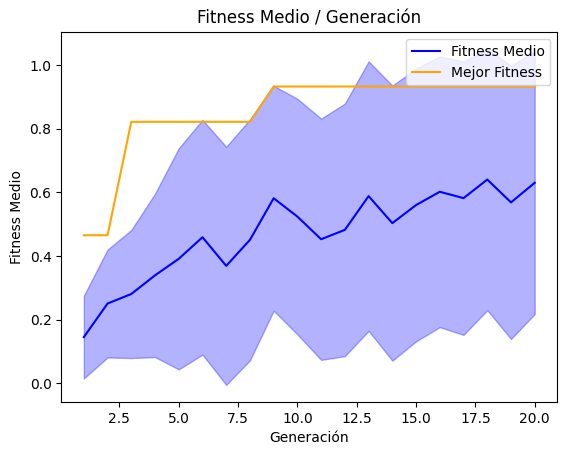

In [ ]:
#Gráfico de convergencia
p,e = ga_template_ar_plot(df_encoded,rangos,variables,10,0.05,100,20,10,60,50,evaluar_arbol,c_intercambio_rama_in,mut_gen_aleat_fijo_p,verbose=True,elitismo=True)

In [ ]:
#Comprobación de que el fitness de la solución y de la solución simplificada es el mismo
evaluar_arbol(df_encoded,variables,rangos,e[0],0.05,verbose=True)==evaluar_arbol(df_encoded,variables,rangos,purificar_arbol(e[0], df_encoded, 5),0.05)

In [ ]:
#Conversión del árbol a consulta
print(from_tree_to_str(e[0][0],columnas_cat,encoders, df_encoded,5))

((((('security_satis_2' IN [4.523420877709098, 5.9841810614547075]) OR ('control_satisf' = '6,33333333333333')) OR ('Social_discon._3R' IN [2.2646213854768, 4.129748251325553])) OR ((('security_satis_2' IN [4.523420877709098, 5.9841810614547075]) OR ('Social_discon._3R' IN [4.929381759440313, 6.272537305022665])) OR ('Social_discon._3R' IN [2.2646213854768, 4.129748251325553]))) AND (('first_group_iden7' IN [1.5223714834331026, 4.04682193699518]) AND ((('control_satisf' = '6,33333333333333') OR ('group_antimain2' IN [4.821440712160613, 6.346666227054179])) AND ('feeling_left' IN [57.67638714191414, 82.84757609446424]))))


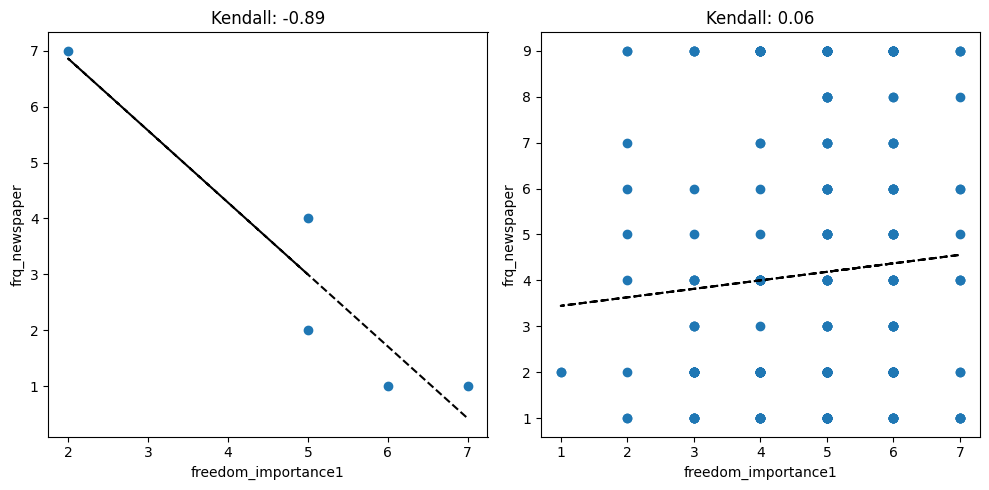

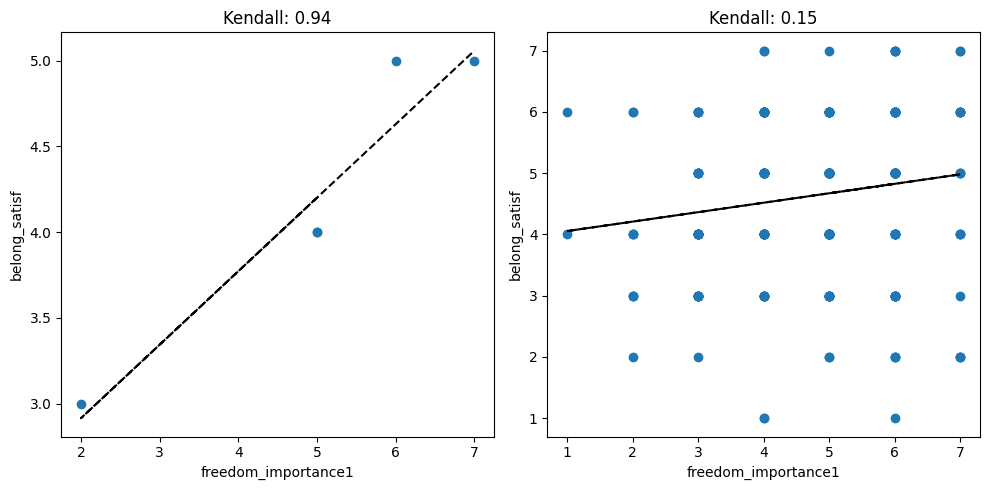

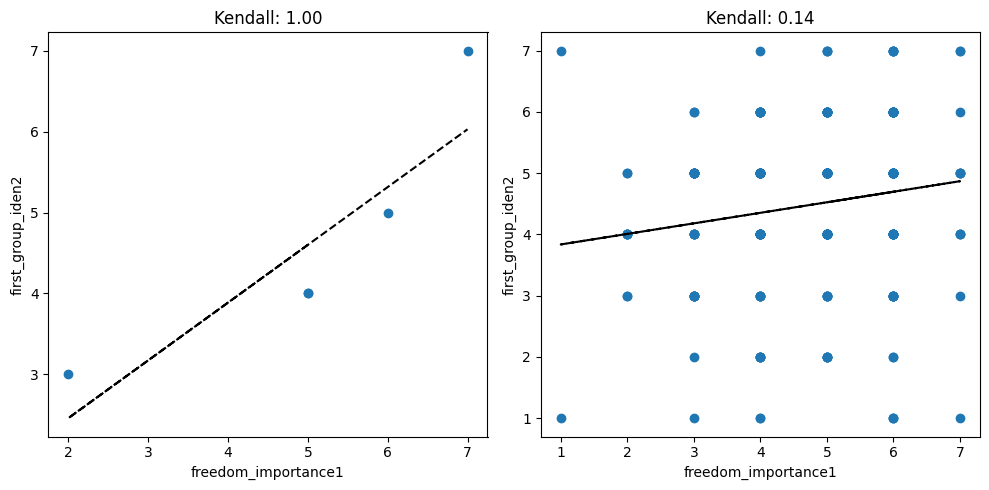

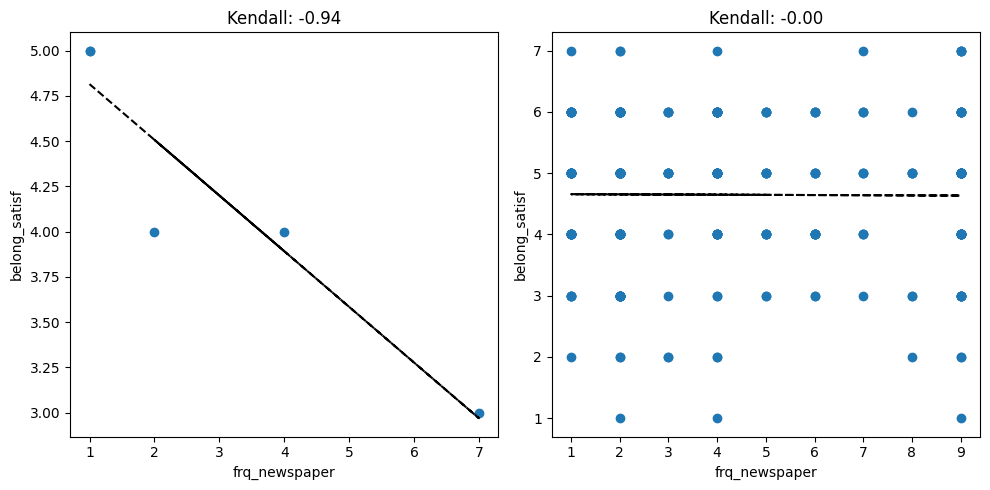

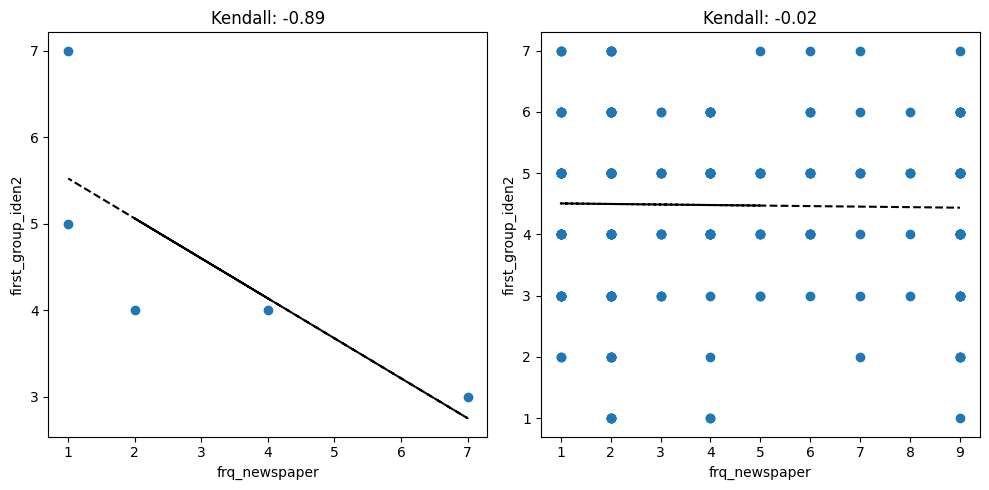

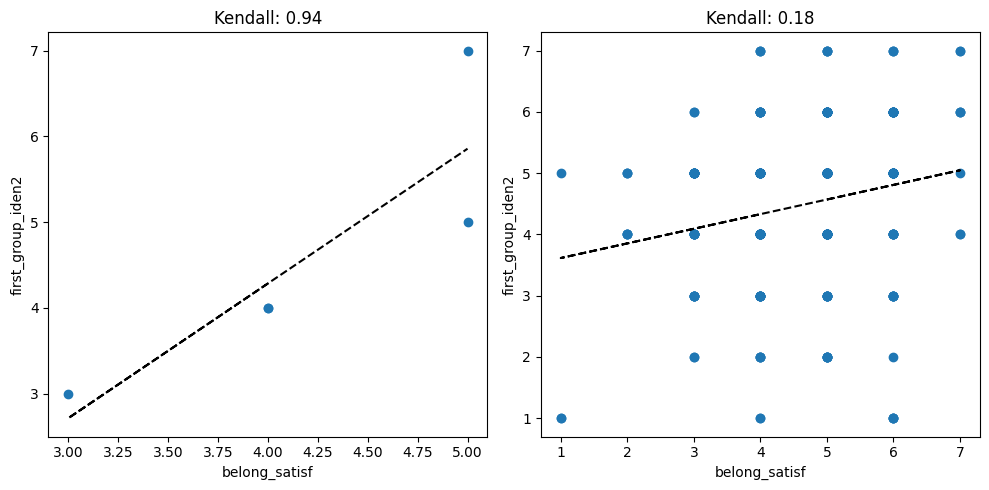

In [ ]:

#Test de la función que dibuja las correlaciones
plot_corrs(e[0][0],variables,df_encoded)

##Prueba rendimiento

###Prueba con 2 variables

In [ ]:
#Se generan 50 tuplas de 2 variables aleatorias
tam_med = 50
vars = []
rangos = []
nvars = 2
r = get_rangos(df_encoded,columnas_cat)
cols = df_encoded.columns
for _ in range(tam_med):
  variables = []



  while(len(variables)<nvars):
    variables = []
    i = random.sample(r,nvars)
    for rs in i:
      if not rs[2]:
        variables.append(cols[rs[0]])



  vars.append(variables)
  rangos.append(get_rangos(df_encoded,columnas_cat,variables))


In [ ]:
#Se ejecuta el algoritmo 50 veces y muestra como va variando la media
fits = []
tiems = []
for i in range(len(vars)):

  t = time()
  p, e = ga_template_ar(df_encoded, rangos[i], vars[i], 10, 0.05, 100, 25, 10, 60, 50, evaluar_arbol, c_intercambio_rama_in, mut_gen_aleat_fijo_p ,verbose=False, elitismo=True)

  tiems.append(time()-t)
  fits.append(e[1])
  print(f'Iteración {i+1}, fitness medio: {np.mean(fits)}, tiempo medio: {np.mean(tiems)}')



Iteración 1, fitness medio: 0.9359691494998894, tiempo medio: 65.3766815662384
Iteración 2, fitness medio: 0.936941784424477, tiempo medio: 48.170488476753235
Iteración 3, fitness medio: 0.9802947114240405, tiempo medio: 39.330453872680664
Iteración 4, fitness medio: 0.9797249128947433, tiempo medio: 40.12914562225342
Iteración 5, fitness medio: 0.9766840129072938, tiempo medio: 37.9816038608551
Iteración 6, fitness medio: 0.9934281615350247, tiempo medio: 36.72573844591776
Iteración 7, fitness medio: 0.987548882154392, tiempo medio: 38.3434008530208
Iteración 8, fitness medio: 1.0147374233573263, tiempo medio: 36.546115070581436
Iteración 9, fitness medio: 1.0193258621144807, tiempo medio: 36.41972949769762
Iteración 10, fitness medio: 1.0399045805842486, tiempo medio: 35.07108905315399
Iteración 11, fitness medio: 1.0455914979544259, tiempo medio: 36.49685634266246
Iteración 12, fitness medio: 1.0381972669447046, tiempo medio: 36.23721436659495
Iteración 13, fitness medio: 1.05352238

In [ ]:
print(f'Fitness Medio: {np.mean(fits)} +-{np.std(fits)}')
print(f'Tiempo Medio: {np.mean(tiems)} +-{np.std(tiems)}')

Fitness Medio: 0.9864161132103068 +-0.2296274472175096
Tiempo Medio: 37.72067880153656 +-12.526678512228255


###Prueba con 3 variables

In [ ]:
#Se generan 50 tuplas de 2 variables aleatorias

tam_med = 50
vars = []
rangos = []
nvars = 3
r = get_rangos(df_encoded,columnas_cat)
cols = df_encoded.columns
for _ in range(tam_med):
  variables = []



  while(len(variables)<nvars):
    variables = []
    i = random.sample(r,nvars)
    for rs in i:
      if not rs[2]:
        variables.append(cols[rs[0]])



  vars.append(variables)
  rangos.append(get_rangos(df_encoded,columnas_cat,variables))


In [ ]:
#Se ejecuta el algoritmo 50 veces y muestra como va variando la media

fits = []
tiems = []
for i in range(len(vars)):

  t = time()
  p, e = ga_template_ar(df_encoded, rangos[i], vars[i], 10, 0.05, 100, 25, 10, 60, 50, evaluar_arbol, c_intercambio_rama_in, mut_gen_aleat_fijo_p ,verbose=False, elitismo=True)

  tiems.append(time()-t)
  fits.append(e[1])
  print(f'Iteración {i+1}, fitness medio: {np.mean(fits)}, tiempo medio: {np.mean(tiems)}')



Iteración 1, fitness medio: 0.7086184085621262, tiempo medio: 46.2978241443634
Iteración 2, fitness medio: 0.8184616844810602, tiempo medio: 44.25917875766754
Iteración 3, fitness medio: 0.8754600577819339, tiempo medio: 43.897534688313804
Iteración 4, fitness medio: 0.8727101025090718, tiempo medio: 44.624778747558594
Iteración 5, fitness medio: 0.8669774672688332, tiempo medio: 45.1955647945404
Iteración 6, fitness medio: 0.8568229443697207, tiempo medio: 42.63686454296112
Iteración 7, fitness medio: 0.8777948843776692, tiempo medio: 42.05232507841928
Iteración 8, fitness medio: 0.8947159174484258, tiempo medio: 41.25625020265579
Iteración 9, fitness medio: 0.9004116887421942, tiempo medio: 41.59263096915351
Iteración 10, fitness medio: 0.8914294480210456, tiempo medio: 40.983229756355286
Iteración 11, fitness medio: 0.8959113853890834, tiempo medio: 40.79967479272322
Iteración 12, fitness medio: 0.89437406021558, tiempo medio: 41.20856157938639
Iteración 13, fitness medio: 0.8904093

In [ ]:
print(f'Fitness Medio: {np.mean(fits)} +-{np.std(fits)}')
print(f'Tiempo Medio: {np.mean(tiems)} +-{np.std(tiems)}')

Fitness Medio: 0.8052931586949265 +-0.1785668473256409
Tiempo Medio: 39.257517037391665 +-7.929153820204658


###Prueba con 4 variables

In [ ]:
#Se generan 50 tuplas de 2 variables aleatorias

tam_med = 50
vars = []
rangos = []
nvars =4
r = get_rangos(df_encoded,columnas_cat)
cols = df_encoded.columns
for _ in range(tam_med):
  variables = []



  while(len(variables)<nvars):
    variables = []
    i = random.sample(r,nvars)
    for rs in i:
      if not rs[2]:
        variables.append(cols[rs[0]])



  vars.append(variables)
  rangos.append(get_rangos(df_encoded,columnas_cat,variables))


In [ ]:
#Se ejecuta el algoritmo 50 veces y muestra como va variando la media

fits = []
tiems = []
for i in range(len(vars)):

  t = time()
  p, e = ga_template_ar(df_encoded, rangos[i], vars[i], 10, 0.05, 100, 25, 10, 60, 50, evaluar_arbol, c_intercambio_rama_in, mut_gen_aleat_fijo_p ,verbose=False, elitismo=True)

  tiems.append(time()-t)
  fits.append(e[1])
  print(f'Iteración {i+1}, fitness medio: {np.mean(fits)}, tiempo medio: {np.mean(tiems)}')



Iteración 1, fitness medio: 0.6068822910982787, tiempo medio: 47.180678606033325
Iteración 2, fitness medio: 0.8264935882538025, tiempo medio: 48.052313566207886
Iteración 3, fitness medio: 0.9770468180188944, tiempo medio: 44.09800624847412
Iteración 4, fitness medio: 0.961149356221392, tiempo medio: 44.666946828365326
Iteración 5, fitness medio: 0.9292578137238683, tiempo medio: 50.692798137664795
Iteración 6, fitness medio: 0.8691476238238991, tiempo medio: 52.47319336732229
Iteración 7, fitness medio: 0.8099396880924246, tiempo medio: 51.79647254943848
Iteración 8, fitness medio: 0.8160706152777165, tiempo medio: 50.977275401353836
Iteración 9, fitness medio: 0.8344399953589408, tiempo medio: 49.62690909703573
Iteración 10, fitness medio: 0.8329636722454452, tiempo medio: 50.81775629520416
Iteración 11, fitness medio: 0.8161202201226178, tiempo medio: 50.649353070692584
Iteración 12, fitness medio: 0.8096454727561683, tiempo medio: 50.52817656596502
Iteración 13, fitness medio: 0.8

In [ ]:
print(f'Fitness Medio: {np.mean(fits)} +-{np.std(fits)}')
print(f'Tiempo Medio: {np.mean(tiems)} +-{np.std(tiems)}')

Fitness Medio: 0.8084543370020321 +-0.17312887506870875
Tiempo Medio: 52.026845645904544 +-10.420467446827049


# **La Sección 'Material para el Usuario' contiene el material necesario para que el Usuario utilice el programa desarrollado. Es decir, en esta sección es en la que debe entrar el Usuario para resolver el problema.**

#Material para el Usuario

En primer lugar, es necesario importar al colab un dataset, para este ejemplo se ha usado el dataset 'cleandata-2.csv', puesto a disposición por los clientes.


La función principal del programa es 'encontrar_subgrupos'. Los parámetros de la función son los siguientes:



**Datos de entrada (`dataInput`)**:  
Este parámetro espera un `DataFrame` con el conjunto de datos en el que se desean encontrar los grupos de interés.

**Variables de entrada (`vInput`)**:  
Este parámetro espera una lista que contenga las variables con las que se desea calcular las correlaciones. Cabe destacar que estas variables deben ser continuas; en el caso de introducir variables categóricas, el algoritmo producirá un error.

**Número de respuestas de salida (`nElite`)**:  
Este parámetro indica el número de soluciones que espera el usuario como respuesta. Estas soluciones representarán las mejores que se han encontrado durante toda la ejecución del algoritmo.

**Umbral de comportamiento excepcional (`exTh`)**:  
Este parámetro numérico indica el valor umbral para considerar si la diferencia de correlaciones entre un grupo y su complementario es significativa.

**Respuestas en forma de consulta (`sOutput`)**:  
Este parámetro, el cual espera verdadero o falso, indica si la salida resultante estará en forma de una consulta SQL o en forma de árbol, respectivamente.

**Mostrar Gráficos (`plotOutput`)**:  
Este parámetro, que espera verdadero o falso, indica si el usuario desea visualizar gráficos de puntos que representan el subgrupo que conforma la mejor solución encontrada, además de indicar las correlaciones entre cada par de variables.

**Profundidad de los árboles (`depthTree`)**:  
Este parámetro indica la profundidad que tendrán las soluciones iniciales, es decir, el número de veces que se aplicarán las reglas de la gramática por individuo a la hora de generar la población inicial. Establecido por defecto en 10.

**Tamaño de la población (`nSolutions`)**:  
Este parámetro indica el número de individuos que tendrá la población a lo largo de la ejecución del algoritmo. Es importante señalar que, debido al tipo de algoritmo elegido, este número se mantendrá siempre constante. Establecido por defecto en 100.

**Número de generaciones (`nGenerations`)**:  
Este parámetro indica el número de generaciones durante las cuales se va a ejecutar el algoritmo. Establecido por defecto en 25.

**Tamaño del torneo (`nTourn`)**:  
Este parámetro indica el número de individuos que se van a seleccionar cada vez que se produzca el torneo. Establecido por defecto en 10.

**Probabilidad de cruce (`pCross`)**:  
Este parámetro indica la probabilidad de que, dados dos individuos seleccionados como padres, se produzca el cruce. Establecido por defecto en 60%.

**Probabilidad de mutación (`pMut`)**:  
Este parámetro indica la probabilidad de que, dado un individuo seleccionado, se produzca la mutación. Establecido por defecto en 50%.


La función devuelve una lista con las mejores soluciones que se han encontrado durante toda la ejecución(El número de soluciones viene definido por `nElite`). Cada elemento de la lista está estructurado de la siguiente forma: [solucion, fitness].

El fitness indica la calidad de la solución, por lo que cuanto mayor sea, mejor solución será.

Ejemplo de uso básico

In [ ]:
df  =pd.read_csv('sample_data/cleandata-2.csv',sep=';')
variables = ['freedom_importance1', 'frq_newspaper', 'belong_satisf', 'first_group_iden2']


Inicia el preprocesado de los datos
El preprocesado de los datos ha terminado en 0.25052881240844727 segundos
El algoritmo comienza a ejecutarse
El algoritmo ha terminado en 58.40963125228882 segundos
Correlaciones de la 1-ésima mejor solución


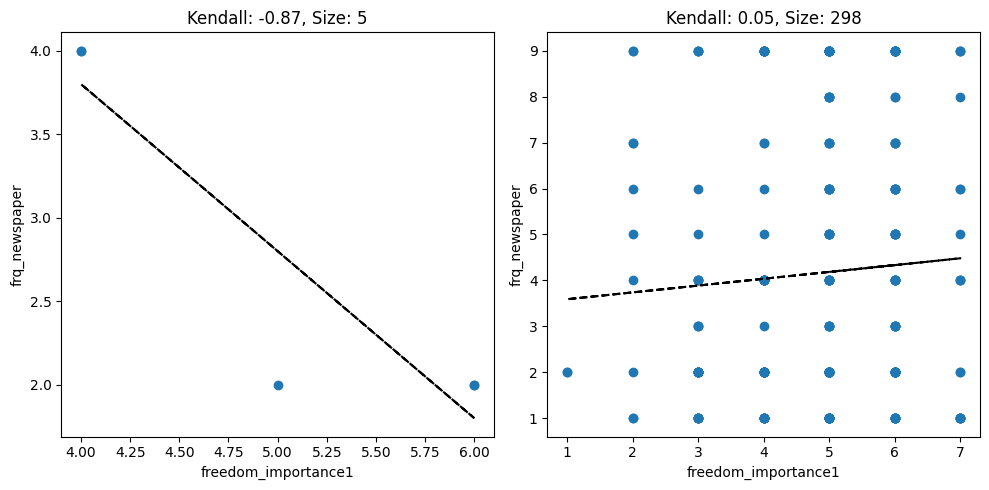

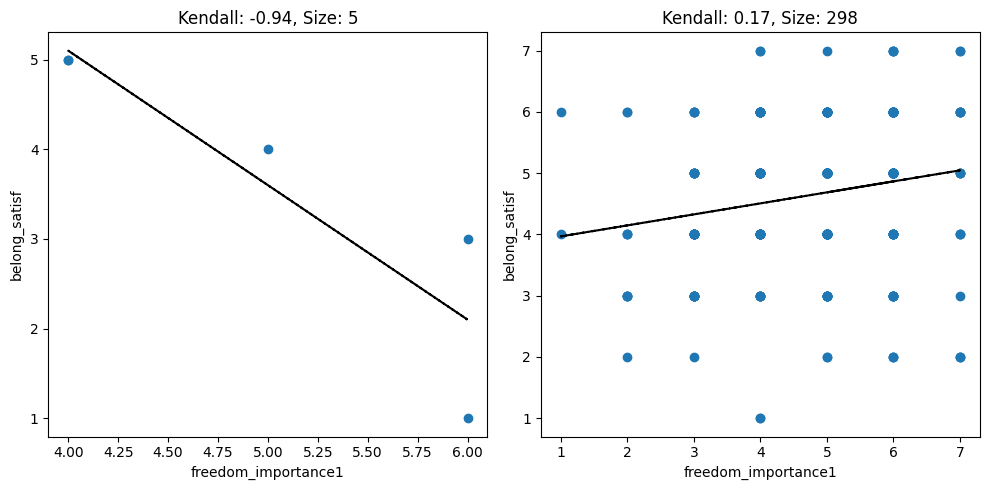

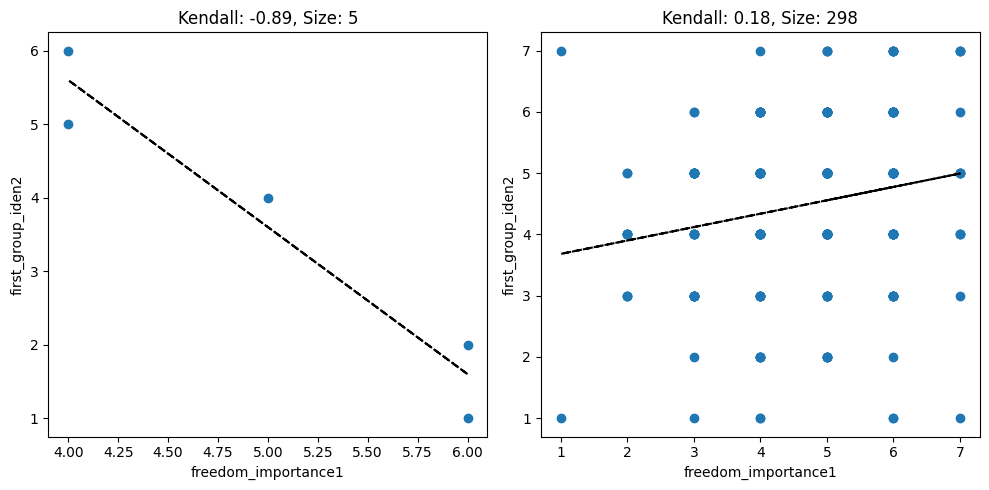

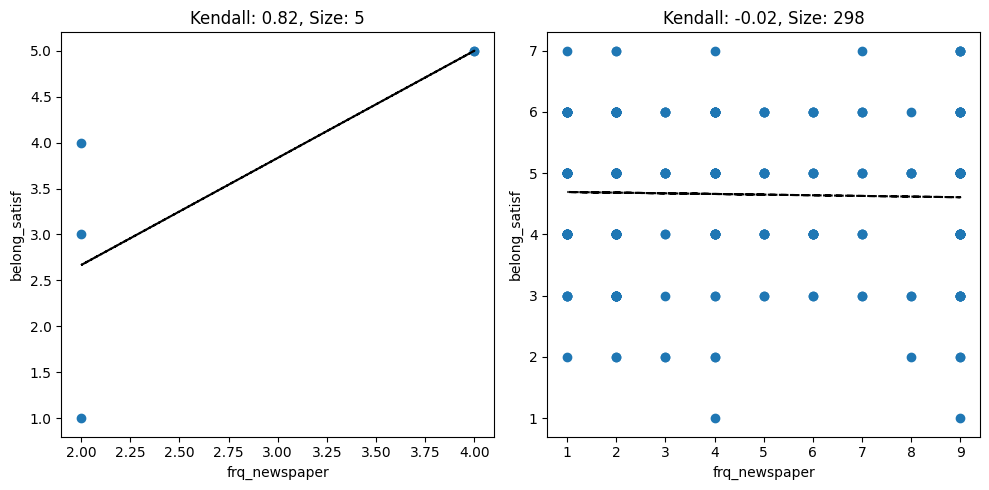

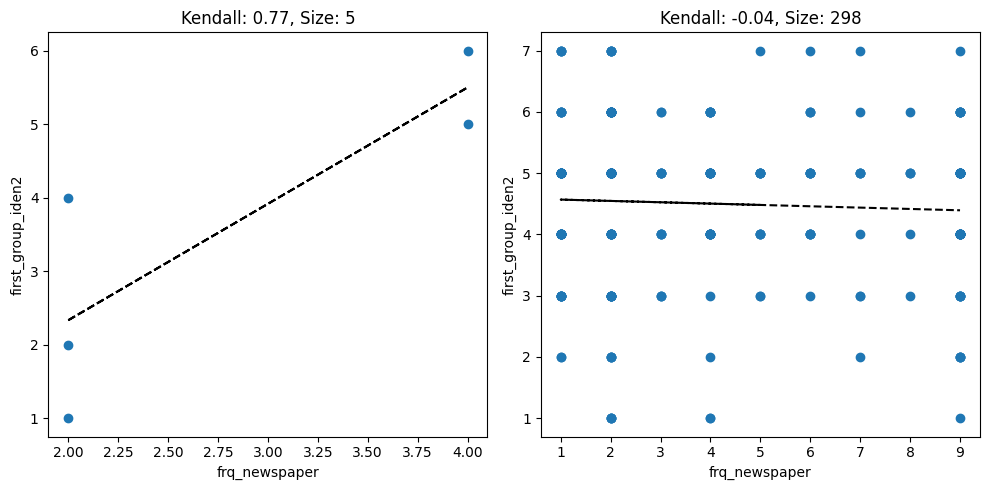

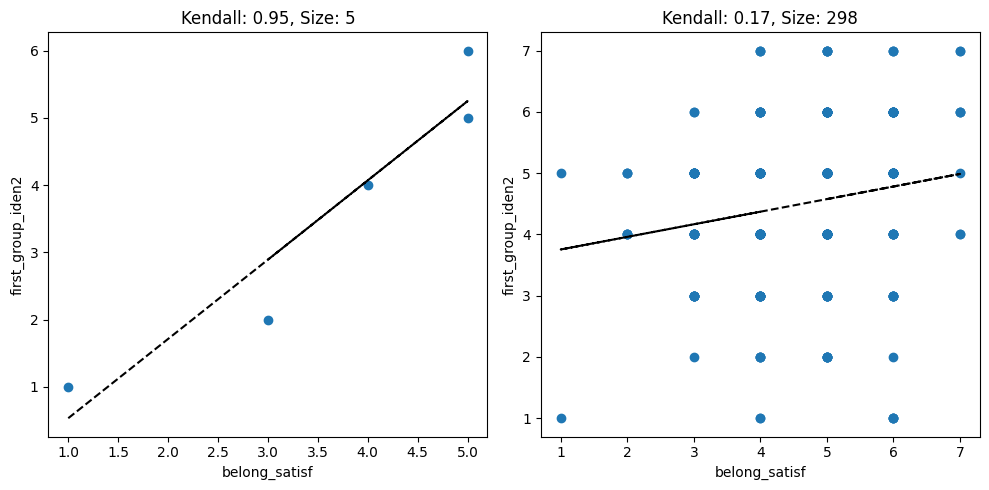

In [ ]:
soluciones = encontrar_subgrupos(dataInput=df,vInput=variables,nElite=1,exTh=0.05,sOutput=True,plotOutput=True)

In [ ]:
print(f'La mejor solución, con un fitness de {soluciones[0][1]} obtenida es:')
print(soluciones[0][0])

La mejor solución, con un fitness de 0.9218674724402965 obtenida es:
((('funct_insta2' IN [4.177709880490253, 5.03091388211978]) OR (('feeling_left' IN [71.77548664634408, 81.14912053454456]) OR (('freedom_importance' = '5,66666666666667') OR ('fuct_selfexpression_Msng' = '4,66666666666667')))) AND (('fuct_identity_FB' = '2,66666666666667') AND (('Gender' IN [1.6107948922090087, 2.4536395780669]) OR (((('ProlificID' = '55e9aa1c735c45001043fbb6') OR ('funct_insta2' IN [4.3948735108869315, 5.3321914161994535])) AND ('funct_insta2' IN [4.177709880490253, 5.03091388211978])) AND (('ProlificID' = '63ff53f7741586a6e8cf5eb7') OR ('freedom_need_2' IN [2.693210753712729, 4.660467573541149]))))))


Ejemplo de uso avanzado

In [ ]:
soluciones = encontrar_subgrupos(dataInput=df,vInput=variables,nElite=1,exTh=0.05,sOutput=True,plotOutput=True,depthTree=10,nSolutions=100,nGenerations=25,nTourn=10,pCross=60,pMut=50)

In [ ]:
print(f'La mejor solución, con un fitness de {soluciones[0][1]} obtenida es:')
print(soluciones[0][0])

La mejor solución, con un fitness de 0.9408246628355447 obtenida es:
((('freedom_importance3' IN [3.7030762791159297, 4.419455405150257]) AND ((('funct_insta3' IN [3.956097023254922, 4.144110940024474]) AND ('frq_youtube' IN [1.4434124960985502, 8.737170971807817])) AND ((('control_satisf_3' IN [1.2802393917153627, 6.756945611937821]) AND ('control_satisf_3' IN [2.5466212872882656, 5.2018298639040985])) OR ((('Social_IBRS_identifi' = '8') AND ('group_gender3' IN [3.2124957426254106, 6.184189974233364])) OR ('freedom_need_1' IN [2.0763300057298846, 4.992874087836739]))))) OR (((('conspiracy_mentality_4' IN [4.062739242775566, 6.0186892819345]) OR ((('funct_insta3' IN [3.956097023254922, 4.144110940024474]) AND (('funct_insta3' IN [3.956097023254922, 4.144110940024474]) AND ('frq_youtube' IN [1.4434124960985502, 8.737170971807817]))) AND ((('freedom_need_1' IN [2.0763300057298846, 4.992874087836739]) AND ('control_satisf_3' IN [2.5466212872882656, 5.2018298639040985])) OR ((((('funct_ins

In [ ]:
df  =pd.read_csv('data.csv',sep=';')

In [ ]:

def convertir_coma_a_punto(cadena):
    if type(cadena)==str:

      return cadena.replace(",", ".")
    else:
      return cadena

for c in df.columns:
    if df[c].dtype == 'object':

          df[c] = df[c].apply(convertir_coma_a_punto)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors='coerce')


In [ ]:
variables = ['freedom','power']


Inicia el preprocesado de los datos
El preprocesado de los datos ha terminado en 0.16554975509643555 segundos
El algoritmo comienza a ejecutarse
El algoritmo ha terminado en 212.19145274162292 segundos
Correlaciones de la 1-ésima mejor solución


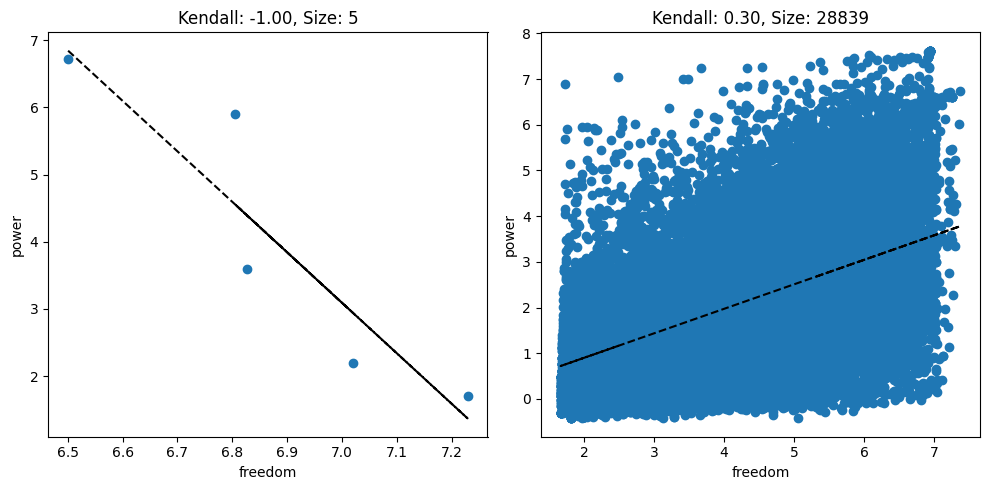

In [ ]:
soluciones = encontrar_subgrupos(dataInput=df,vInput=variables,nElite=1,exTh=0.05,sOutput=True,plotOutput=True)

In [ ]:
soluciones[0]

["(('mistrust' IN [4.161266929403386, 5.322015351092048]) AND ((('id_skeptics' IN [2.3051477641077684, 3.177393526484523]) AND ('security' IN [6.350812071078141, 6.481568868879545])) AND (('mistrust' IN [4.161266929403386, 5.322015351092048]) AND ('politicalorientation' IN [1.8306921714484026, 8.311392639563053]))))",
 1.3009774855561265]